In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
import yfinance as yf
from scipy.optimize import fsolve
from scipy import stats
import scipy.stats
import statsmodels.api as sm
import random

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download historical data for NSE Nifty 50 index (^NSEI)
df = yf.download('^NSEI')

df['Date'] = df.index
prices = df['Close'].values
log_returns = np.log(prices[1:] / prices[:-1])

df['Log Returns'] = np.log(df['Close'] / df['Close'].shift(1))

# Calculate mean, variance, skewness, and kurtosis
mean = np.mean(log_returns)
var = np.var(log_returns)
skew = scipy.stats.skew(log_returns)
kurt = scipy.stats.kurtosis(log_returns)


[*********************100%%**********************]  1 of 1 completed


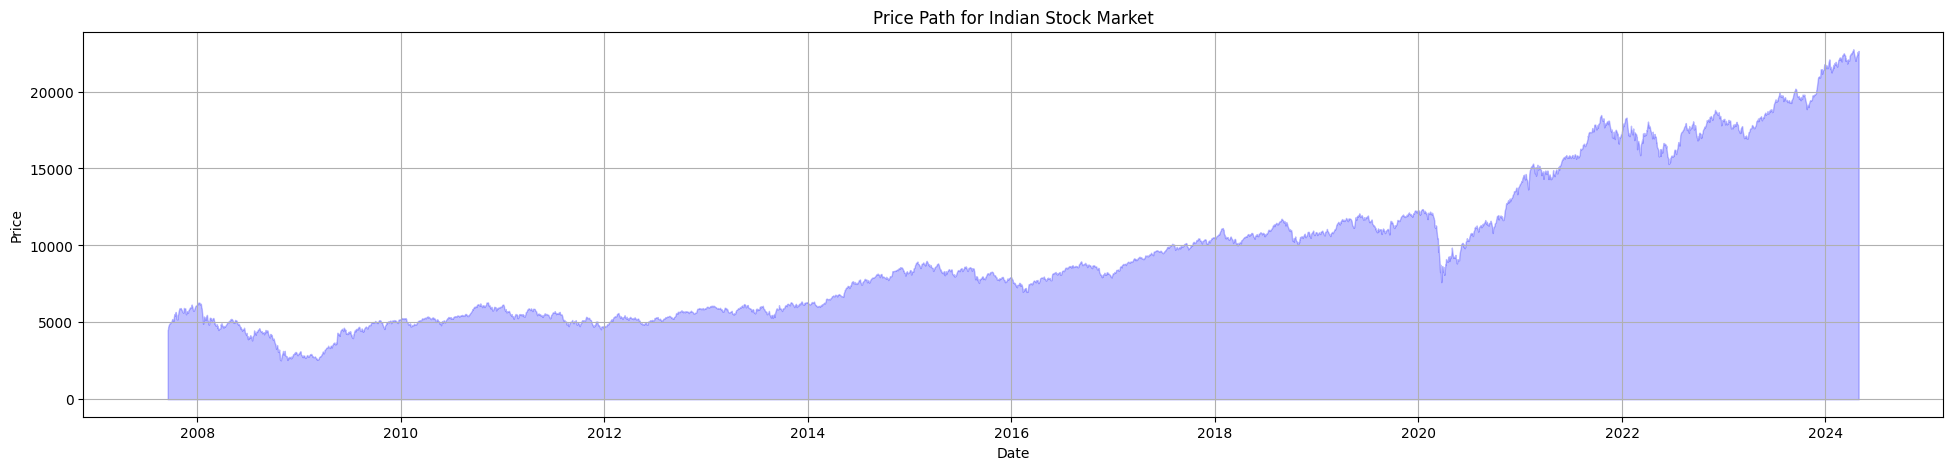

In [3]:
plt.figure(figsize=(24, 5))
plt.grid(visible=True)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Price Path for Indian Stock Market")

plt.fill_between(df['Date'], df['Close'], color="blue", alpha=0.25)

plt.show()


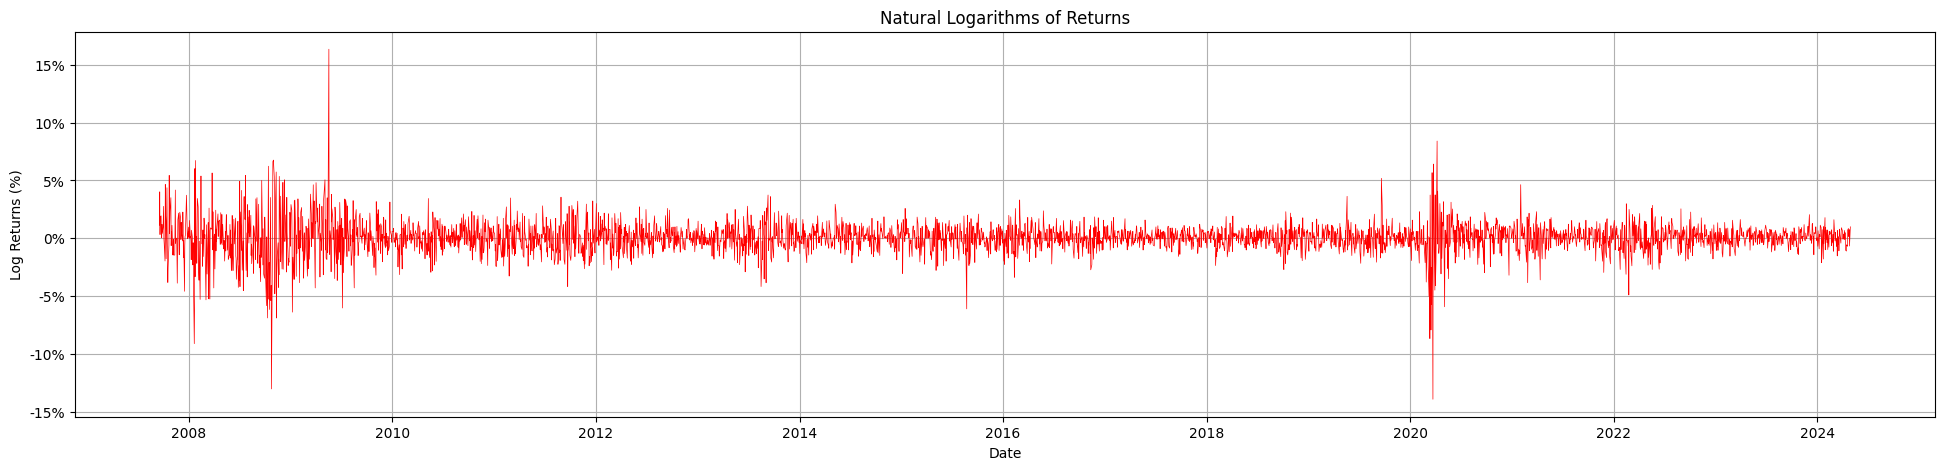

In [4]:
plt.figure(figsize=(24, 5))
plt.grid(visible=True)

plt.xlabel('Date')
plt.ylabel('Log Returns (%)')
plt.title("Natural Logarithms of Returns")

plt.plot(df['Date'], df['Log Returns'], color="red", linewidth=0.5)

plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])

plt.show()


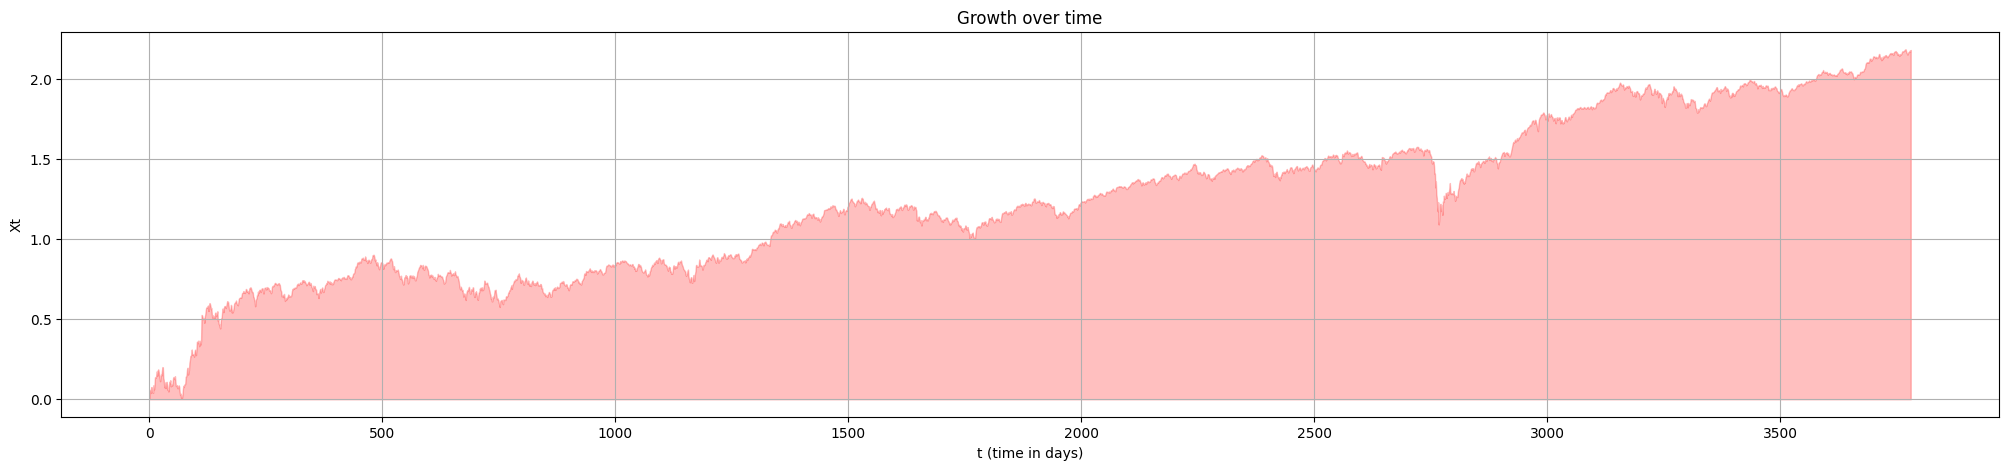

In [5]:
# Calculate Xt directly
df = df[-3781:]

df['Xt'] = np.log(df['Close']) - np.log(df['Close'].iloc[0])

# Create a 't' column representing time
df['t'] = range(len(df))

# Plot the growth of Xt over time
plt.figure(figsize=(25, 5))
plt.grid(visible=True)
plt.xlabel('t (time in days)')
plt.ylabel('Xt')
plt.title("Growth over time")
plt.fill_between(df['t'], df['Xt'], color="red", alpha=0.25)
plt.show()


To ensure a comprehensive analysis, we choose a highly composite number - 3780 - as our total number of observations.

This choice offers numerous factors, allowing for diverse time increments, denoted as 'delta_t'.

In [6]:
delta_t = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 18, 20, 21, 24, 27, 28, 30, 35, 36, 40, 42, 45, 54, 56, 60, 63, 70, 72, 84, 90, 105, 108, 120, 126, 135, 140, 168, 180, 189, 210, 216, 252, 270, 280, 315, 360, 378, 420, 504, 540, 630, 756, 840, 945, 1080, 1260, 1512, 1890, 2520, 3780)

# Printing the factors
print("Number of time increments ('delta_t') used in the analysis:", len(delta_t))


Number of time increments ('delta_t') used in the analysis: 63


Now, let's select the values of q - the statistical moments - for our partition function.

However, for our purposes, we'll simplify and treat all moments as 'raw' without normalization.

In [7]:
# Define the values of q
q = [0.01, 0.1, 0.2, 0.3, 0.4,
     0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95,
     1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45,
     1.5, 1.55, 1.6, 1.65, 1.7, 1.75,
     1.8, 1.81, 1.82, 1.83, 1.84, 1.85, 1.86, 1.87, 1.88, 1.89,
     1.9, 1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.985, 1.99,
     1.991, 1.992, 1.993, 1.994, 1.995, 1.996, 1.997, 1.998, 1.999,
     2.0,
     2.001, 2.002, 2.003, 2.004, 2.005, 2.006, 2.007, 2.008, 2.009,
     2.01, 2.015, 2.02, 2.025,
     2.03, 2.04, 2.05, 2.06, 2.07, 2.08, 2.09,
     2.1, 2.15, 2.2, 2.25, 2.3, 2.35, 2.4, 2.45, 2.5,
     2.6, 2.7, 2.8, 2.9,
     3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
     4.0, 4.5,
     5.0, 6.0, 7.0, 8.0, 9.0, 10.0,
     12.5, 15.0, 17.5, 20.0, 22.5, 25.0, 27.5,
     30.0]

# Printing the number of q values
print("\nThe number of q's to be used is", len(q))



The number of q's to be used is 121


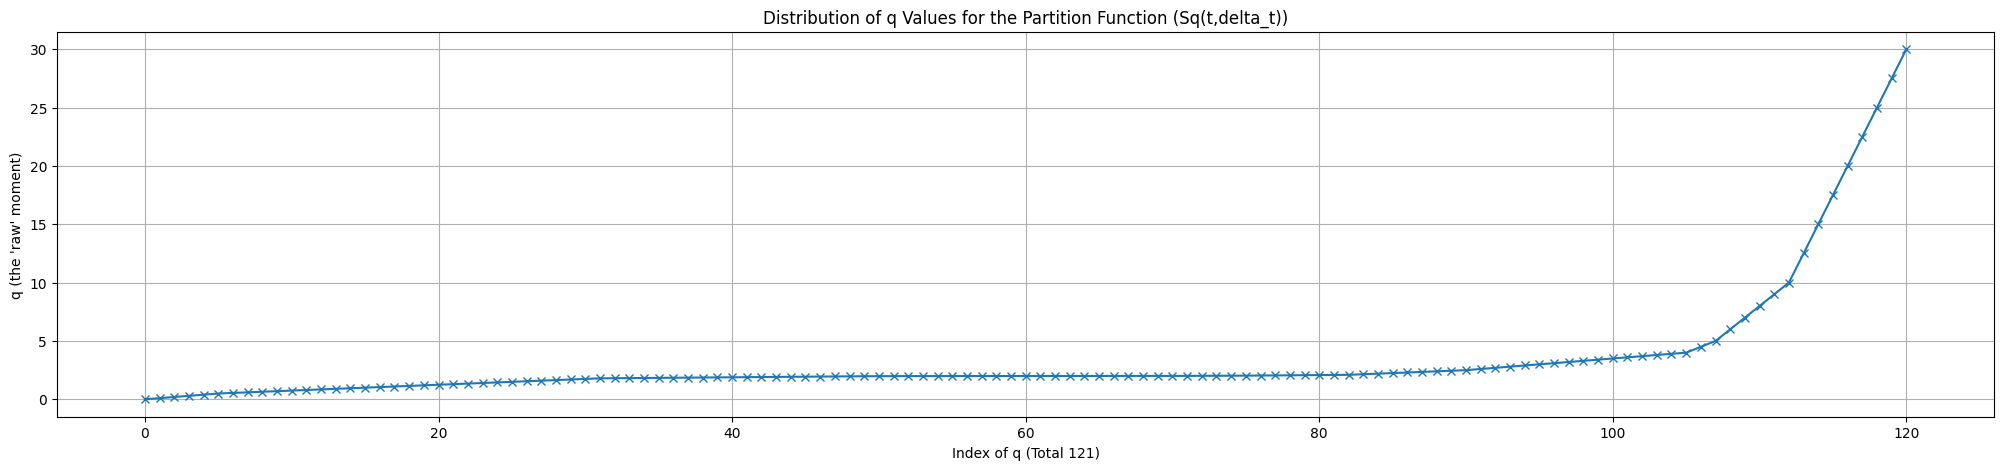

In [8]:
# Plotting the distribution of q values used for the Partition Function (Sq(t,delta_t))
plt.figure(figsize=(25, 5))
plt.grid(visible=True)

plt.title("Distribution of q Values for the Partition Function (Sq(t,delta_t))")
plt.xlabel("Index of q (Total {})".format(len(q)))
plt.ylabel("q (the 'raw' moment)")

# Plotting the q values
plt.plot(q, marker='x')


In [9]:
def partition_function(SIGMA, DELTA, XT, Q):
    SIGMA=[[0 for x in range(len(DELTA))] for y in range(len(Q))]
    for k in range (0, len(Q)):
        if k%30==0:
            print("calculating i=" + str(k) + ' out of ' + str(len(Q)-1))
        for j in range (0,len(DELTA)):
            for i in range (0,len(XT)-1):
                if i < int(len(XT)/DELTA[j]):
                    SIGMA[k][j]=SIGMA[k][j] + abs(XT[i*DELTA[j]+DELTA[j]]-XT[i*DELTA[j]])**Q[k]

    SIGMA=pd.DataFrame(SIGMA)
    
    for i in range (0,len(Q)):
        SIGMA.rename(index={SIGMA.index[i]:Q[i]}, inplace=True)
    for i in range (len(DELTA)-1,-1,-1):
        SIGMA.rename(columns={SIGMA.columns[i]:DELTA[i]}, inplace=True)
    
    return SIGMA

Let's calculate the partition function, Sq(T, delta_t), for various values of delta_t and q.

The partition function Sq(T, delta_t) will help us estimate the scaling function tau(q).

In [10]:


# Define the partition function
def partition_function(SIGMA, DELTA, XT, Q):
    SIGMA = [[0 for _ in range(len(DELTA))] for _ in range(len(Q))]
    for k in range(len(Q)):
        for j in range(len(DELTA)):
            for i in range(len(XT) - 1):
                if i < int(len(XT) / DELTA[j]):
                    SIGMA[k][j] += abs(XT[i * DELTA[j] + DELTA[j]] - XT[i * DELTA[j]]) ** Q[k]

    SIGMA = pd.DataFrame(SIGMA)
    
    # Renaming rows and columns for clarity
    SIGMA.rename(index={i: q_value for i, q_value in enumerate(Q)}, inplace=True)
    SIGMA.rename(columns={i: delta_value for i, delta_value in enumerate(DELTA[::-1])}, inplace=True)
    
    print("Partition function calculation complete!\n")
    return SIGMA



In [11]:
partition_NSE=[[]]

partition_NSE=partition_function(partition_NSE, delta_t, df.Xt, q)

Partition function calculation complete!



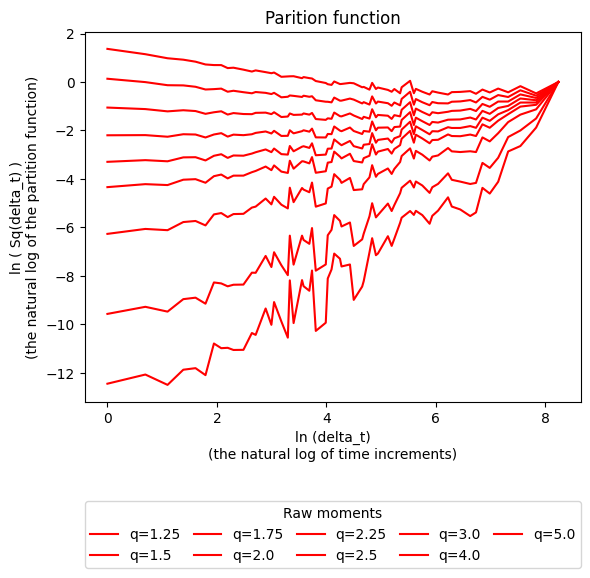

In [12]:
for i in range (0, len(q)):
    if q[i]%0.25==0 and q[i]<6 and q[i]>1 and q[i]!=3.5 and q[i]!=4.5:
        plt.plot(np.log(delta_t), np.log(list(partition_NSE.iloc[i])/partition_NSE[1][q[i]]), color="red", linewidth=1.5, label='q='+str(q[i]))


plt.legend(bbox_to_anchor=(0., -0.45, 1., .102), loc=3,
           ncol=5, mode="expand", borderaxespad=0., title="Raw moments")

plt.title("Parition function")
plt.xlabel('ln (delta_t)\n(the natural log of time increments)')
plt.ylabel('ln ( Sq(delta_t) )\n(the natural log of the partition function)')

plt.show()

In [13]:
tau_regression=pd.DataFrame(np.log(delta_t))
tau_regression['LN_DELTA']=pd.DataFrame(np.log(delta_t))
tau_regression['LN_T']=[np.log(7560) for x in range(len(delta_t))]

def scaling_function(TAU_Q, PARTITION, Q):
    TAU_Q=[0 for x in range(len(Q))]
    
    for i in range(0,len(Q)):
        TAU_Q[i]=((sm.OLS(endog=np.log(list(PARTITION.iloc[i]/PARTITION[1][Q[i]])), exog = tau_regression[['LN_DELTA','LN_T']], missing='drop')).fit()).params[0]
    
    TAU_Q=pd.DataFrame(TAU_Q)

    return TAU_Q


Here we have defined how to find the estimated scaling function tau_q. \n\nWe are now ready to estimate tau_q for each market.


In [14]:
tau_q_NSE=0

tau_q_NSE = scaling_function(tau_q_NSE, partition_NSE, q)


hypothetical_tau_q = [0.5*x -1 for x in q]

In [15]:
from hurst import compute_Hc

prices = df['Close'].values

log_returns = np.log(prices[1:] / prices[:-1])

X = log_returns

H_NSE, c, data = compute_Hc(X, kind='change', simplified=True)

print("H for NSE is " , H_NSE)

H for NSE is  0.611711810149753



Here we have defined the highest moment q which we will use for estimating the multifractal spectrum.

In [16]:
max_q=95

In [17]:

def estimate_multifractal_spectrum(TAU_Q, Q, MIN_Q, MAX_Q):
    TAU_Q_ESTIMATED = np.polyfit(Q[MIN_Q:MAX_Q], TAU_Q[MIN_Q:MAX_Q], 2)
    
    F_A = [0 for x in range(len(q)-10)]
    p = [0 for x in range(len(q)-10)]
    
    a = TAU_Q_ESTIMATED[0][0]
    b = TAU_Q_ESTIMATED[1][0]
    c = TAU_Q_ESTIMATED[2][0]
    
    for i in range(0, len(q)-10):
        p[i] = 2*a*Q[i]+b
        F_A[i] = ((p[i]-b)/(2*a))*p[i] - (a*((p[i]-b)/(2*a))**2 + b*((p[i]-b)/(2*a)) + c)
    
    F_A = pd.DataFrame(F_A)
    F_A.rename(columns={F_A.columns[0]:"f(a)"}, inplace=True)
    F_A['p'] = p
    
    print("Using the range of q's from " + str(Q[MIN_Q]) + " to " + str(Q[MAX_Q]) + ":")
    print("The estimated parameters for tau(q) are: \n" + str(TAU_Q_ESTIMATED))
    print("\nThus, the estimated parameters for f(a) are: \n" + str(1/(4*a)) + ", \n"  + str((-2*b)/(4*a)) + ", \n"+ str((-4*a*c+b**2)/(4*a)))
    
    return F_A

In [18]:
f_a_NSE = estimate_multifractal_spectrum(tau_q_NSE, q, 0, max_q)

Using the range of q's from 0.01 to 3.0:
The estimated parameters for tau(q) are: 
[[-0.03918459]
 [ 0.68306195]
 [-1.01291735]]

Thus, the estimated parameters for f(a) are: 
-6.380058478654123, 
8.715950412945588, 
-1.9638497106010868


In [19]:
def lambda_mean(H,ALPHA):
    LAMBDA = ALPHA/H
    return LAMBDA

def sigma_variance(LAMBDA, B):
    SIGMA_VARIANCE = (2*(LAMBDA-1))/np.log(B)
    return SIGMA_VARIANCE

Assuming we will partition our multifractal cascade in two at each step, meaning b=2.

In [20]:
b=2
lambda_NSE = lambda_mean(H_NSE, f_a_NSE['p'][0])
sigma_NSE = sigma_variance(lambda_NSE, b)

print("\nFor NSE, we estimate\n  𝜆 = " + str(lambda_NSE) + "\n  𝜎^2 = " + str(sigma_NSE))


For NSE, we estimate
  𝜆 = 1.1153589812776359
  𝜎^2 = 0.33285566042249615


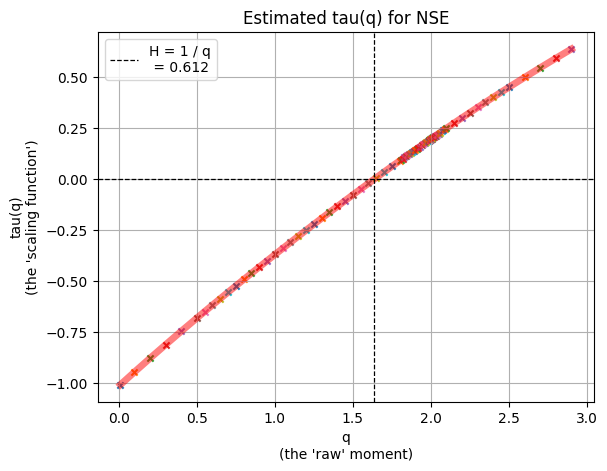


For NSE, we estimate
  𝜆 = 1.1153589812776359
  𝜎^2 = 0.33285566042249615


In [21]:
tau_q_ESTIMATED_NSE=0

tau_q_ESTIMATED_NSE=np.polyfit(q[0:max_q],tau_q_NSE[0:max_q],2)

for i in range(0,max_q):
    plt.scatter(q[i], (tau_q_ESTIMATED_NSE[0][0]*(q[i]**2) + tau_q_ESTIMATED_NSE[1][0]*q[i] + tau_q_ESTIMATED_NSE[2][0]), s = 20, marker='x')

plt.plot(q[0:max_q], tau_q_NSE[0:max_q], color="red",linewidth=5, alpha = 0.5)

plt.grid(visible=True)
plt.title("Estimated tau(q) for NSE")
plt.xlabel("q\n(the 'raw' moment)")
plt.axvline(1/H_NSE, color="black", linestyle='--', linewidth=0.9, label = "H = 1 / q\n = " + str(round(H_NSE, 3)))
plt.axhline(0, color="black", linestyle='--', linewidth=0.9)
plt.ylabel("tau(q)\n(the 'scaling function')")
plt.legend()
plt.show()

print("\nFor NSE, we estimate\n  𝜆 = " + str(lambda_NSE) + "\n  𝜎^2 = " + str(sigma_NSE))

In [22]:
from fbm import FBM
from fbm import fbm, fgn, times
from fbm import MBM
from fbm import mbm, mgn, times

import math

In [23]:
def lognormal_cascade(k, v,ln_lambda, ln_theta):
    
    k = k - 1

    m0 = np.random.lognormal(ln_lambda,ln_theta)
    m1 = np.random.lognormal(ln_lambda,ln_theta)
    M = [m0, m1]
    
    if (k >= 0):
        d=[0 for x in range(0,2)]
        for i in range(0,2):
            d[i] = lognormal_cascade(k, (M[i]*v), ln_lambda, ln_theta)
        
        v = d

    return v


In [24]:
def MMAR(K, simulated_H, simulated_lambda, simulated_sigma, original_price_history, magnitude_parameter):


    print("Performing an MMAR simulation with parameters:\n\nH = " + str(simulated_H) + "\nlambda = " + str(simulated_lambda) + "\nsigma = " + str(simulated_sigma) + "\nfBm magnitude = " + str(magnitude_parameter)+ "\n")

    new_cascade = list(np.array(lognormal_cascade(k=K, v=1, ln_lambda = simulated_lambda, ln_theta = simulated_sigma)).flat)

    tradingtime = 2**K*np.cumsum(new_cascade)/sum(new_cascade)

    new_fbm_class = FBM(n = 10*2**K+1, hurst = simulated_H, length = magnitude_parameter, method='daviesharte')
    new_fbm_simulation = new_fbm_class.fbm()
    
    plt.figure(figsize=(24,4))
    plt.xticks(np.arange(0, 10*2**(K)+1, 10*2**(K-3)))
    plt.title("Fractional Brownian Motion")
    plt.xlabel("t")
    plt.ylabel('fBm (t)')
    plt.plot(new_fbm_simulation, color="orange")
    plt.show()

    simulated_xt_array = [0 for x in range(0, len(tradingtime))]

    for i in range(0, len(tradingtime)):
        simulated_xt_array[i] = new_fbm_simulation[int(tradingtime[i]*10)]

    simulated_price_array = original_price_history[-1]*np.exp(simulated_xt_array)
    
    plt.figure(figsize=(24,4))
    plt.title("MMAR generated Price")
    plt.xticks(np.arange(0, 2**(K)+1, 2**(K-3)))
    plt.xlabel("Time\n(days)")
    plt.ylabel('Price level')
    plt.grid(visible=True)
    plt.fill_between(np.arange(0, 2**K, 1) , simulated_price_array, color="limegreen", alpha=0.2)
    plt.show()

    ln_simulated_xt_array = [0 for x in range(0, len(simulated_xt_array)-1)]

    for i in range(1,len(simulated_xt_array)):
        ln_simulated_xt_array[i-1] = np.log((original_price_history[-1]*np.exp(simulated_xt_array[i]))/(original_price_history[0]*np.exp(simulated_xt_array[i-1])))
            
    plt.figure(figsize=(24,4))
    plt.title("Price increments")
    plt.xticks(np.arange(0, 2**(K)+1, 2**(K-3)))
    plt.xlabel("Time\n(days)")
    plt.ylabel('Change\n(%)')
    plt.grid(visible=True)
    plt.plot(ln_simulated_xt_array, color="darkviolet", linewidth=0.5)
    plt.gca().set_yticklabels(['{:.0f}'.format(x*100) for x in plt.gca().get_yticks()]) 
    plt.show()
    
    return simulated_price_array

Performing an MMAR simulation with parameters:

H = 0.611711810149753
lambda = 1.1153589812776359
sigma = 0.33285566042249615
fBm magnitude = 0.15



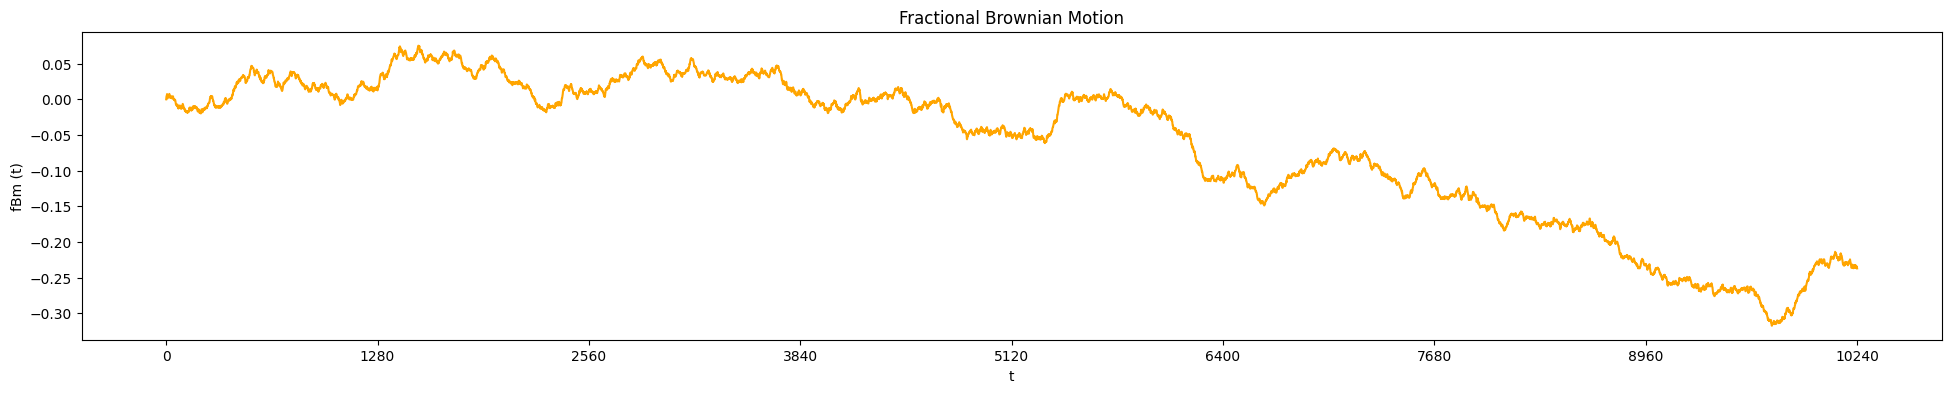

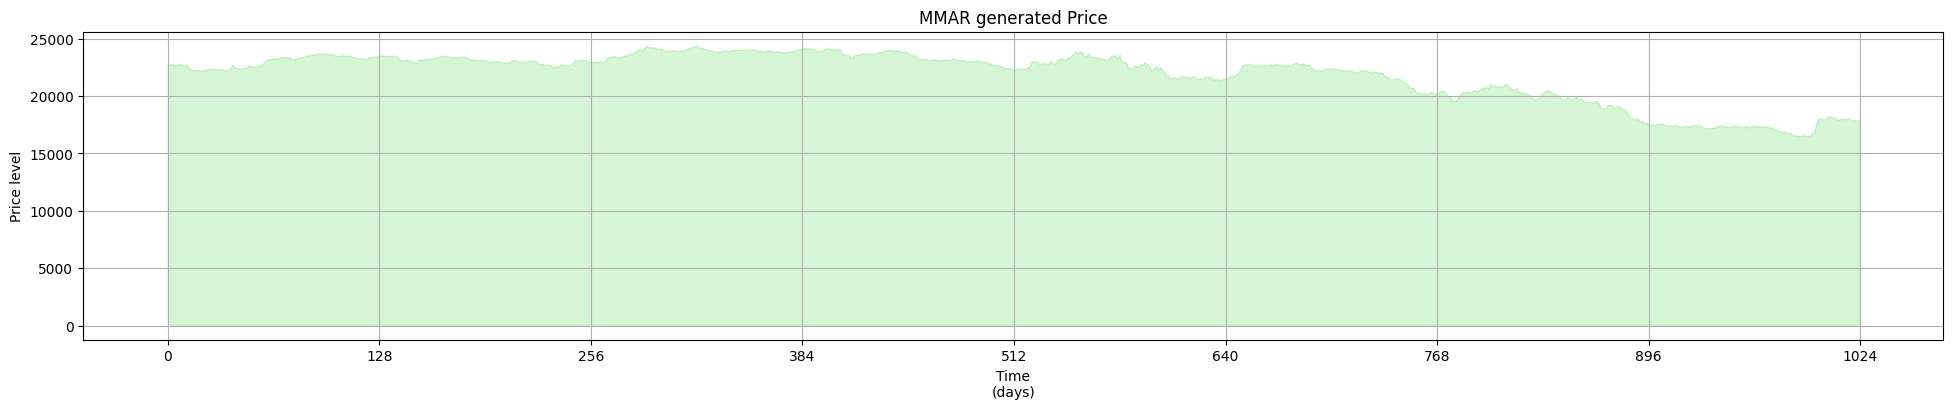

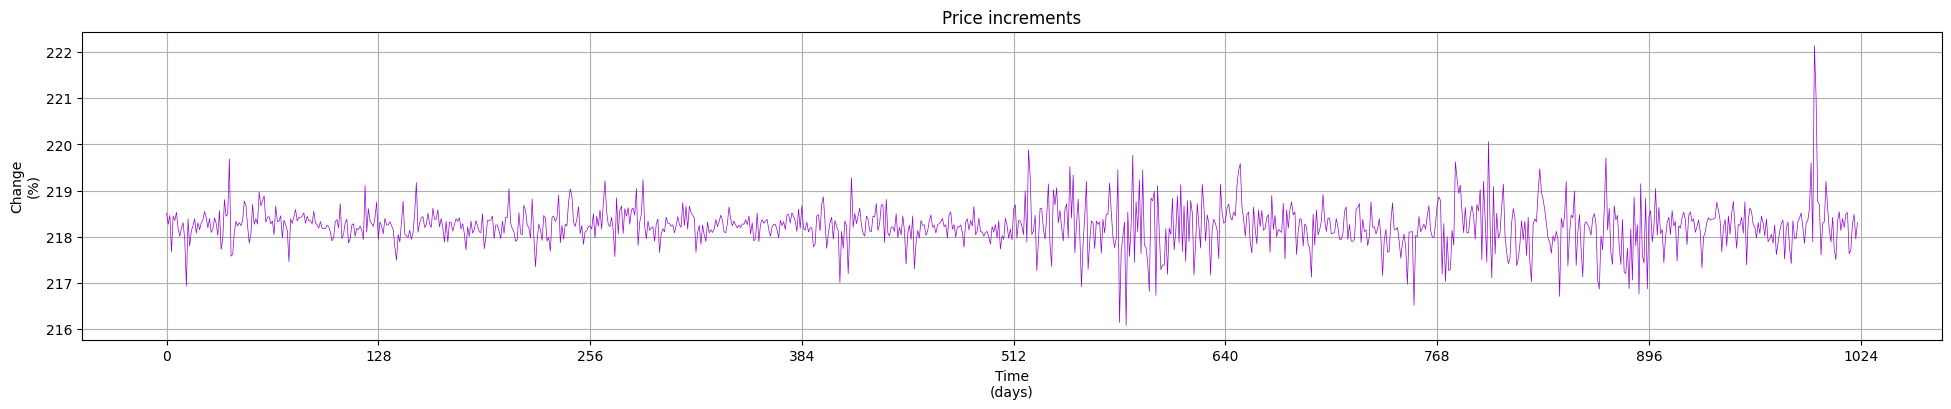

In [25]:
MMAR_price_array = MMAR(10, H_NSE, lambda_NSE, sigma_NSE, df.Close, 0.15)

In [26]:
MMAR_price_array

array([22695.51836425, 22754.25721127, 22757.70749673, ...,
       17925.30463911, 17871.12958642, 17880.12734257])